                                                    Проект №2 
                                             Подготовила Верешко Анна 
                 Тема исследования: "Будет ли задержка в выплатах в зависимости от характеристик заемщика"

Часть 1. Загрузка необходимых пакетов и обработка датасета

In [1]:
# Загружаем и подключаем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import svm, metrics, linear_model, neural_network
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.datasets as datasets
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist

In [2]:
# Загружаем два датасета. В датасете a у нас храниться информация о параметрах заемщиков, например, пол, доход и т.д., а в датасете
# b хранится информация о том, есть ли у заемщика задолженность
a = pd.read_csv("application_record.csv")
b = pd.read_csv("credit_record.csv")

In [3]:
np.random.seed(100) # Обеспечиваем повторяемость эксперимента 

In [4]:
# Соединим два датасета
merged = a.merge(b, on = "ID")
merged

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


Проведем на данных необходимые преобразования данных

In [5]:
merged = merged[merged.STATUS != "X"] # удалим те наблюдения, в которых заемщики не брали кредит 
merged = merged[merged.MONTHS_BALANCE == 0] # оставляем только текущий месяц, чтобы заемщиков не повторялись наблюдения 
merged['Gender'] = np.where(merged['CODE_GENDER'] == "M", 1 ,0)
merged['Property'] = np.where(merged['FLAG_OWN_REALTY'] == "Y", 1 ,0)
merged = merged.drop('ID', 1)
merged = merged.drop('CODE_GENDER', 1)
merged = merged.drop('FLAG_OWN_CAR', 1)
merged = merged.drop('FLAG_OWN_REALTY', 1)
merged

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Gender,Property
0,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1
16,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1
31,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1,1
61,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0,1
71,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0,5,1,1
777634,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1
777658,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1
777691,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0,2,0,1


In [6]:
merged['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [7]:
# Создадим бинарную переменную Working, равную 1, если заемщик работает, и равную 0, если заемщик не имеет работы
merged['Working'] = np.where(merged['NAME_INCOME_TYPE'] == "Working", 1 , np.where(merged['NAME_INCOME_TYPE'] == "Commercial associate", 1 , np.where(merged['NAME_INCOME_TYPE'] == "State servant", 1, 0)))
merged

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Gender,Property,Working
0,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1
16,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1
31,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1,1,1
61,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0,1,1
71,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0,5,1,1,1
777634,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,1
777658,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,0
777691,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0,2,0,1,1


In [8]:
merged['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [9]:
# Создадим бинарную переменную University, равную 1, если заемщик имеет высшее образование или ученую степень, и равную 0, если иначе
merged['University'] = np.where(merged['NAME_EDUCATION_TYPE'] == "Higher education", 1 , np.where(merged['NAME_EDUCATION_TYPE'] == "Academic degree", 1, 0))
merged

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Gender,Property,Working,University
0,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1,1
16,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1,1
31,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1,1,1,0
61,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0,1,1,0
71,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0,5,1,1,1,0
777634,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,1,1
777658,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,0,1
777691,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0,2,0,1,1,0


In [10]:
#Возьмем абсолютные значения переменных, так как в исходном датасете они со знаком минус
merged['Age_Days'] = abs(merged['DAYS_BIRTH']) # abs - возвращает абсолютную величину
merged['Job_Days'] = abs(merged['DAYS_EMPLOYED'])

In [11]:
#Избавимся от уже ненужных столбцов
merged = merged.drop('NAME_INCOME_TYPE', 1)
merged = merged.drop('NAME_FAMILY_STATUS', 1)
merged = merged.drop('NAME_HOUSING_TYPE', 1)
merged = merged.drop('NAME_EDUCATION_TYPE', 1)
merged = merged.drop('OCCUPATION_TYPE', 1)
merged = merged.drop('DAYS_BIRTH', 1)
merged = merged.drop('DAYS_EMPLOYED', 1)
merged = merged.drop('MONTHS_BALANCE', 1)
merged = merged.drop('FLAG_MOBIL', 1)
merged = merged.drop('FLAG_EMAIL', 1)
merged = merged.drop('FLAG_WORK_PHONE', 1)
merged = merged.drop('FLAG_PHONE', 1)
merged = merged.drop('CNT_CHILDREN', 1)
merged

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,STATUS,Gender,Property,Working,University,Age_Days,Job_Days
0,427500.0,2.0,C,1,1,1,1,12005,4542
16,427500.0,2.0,C,1,1,1,1,12005,4542
31,112500.0,2.0,C,1,1,1,0,21474,1134
61,270000.0,1.0,0,0,1,1,0,19110,3051
71,270000.0,1.0,C,0,1,1,0,19110,3051
...,...,...,...,...,...,...,...,...,...
777622,315000.0,2.0,5,1,1,1,0,17348,2420
777634,157500.0,2.0,C,0,1,1,1,12387,1325
777658,157500.0,2.0,C,0,1,0,1,12387,1325
777691,283500.0,2.0,2,0,1,1,0,17958,655


In [12]:
#удалим строчки, в которых есть хотя бы 1 значение NA и восстановим индексацию
merged = merged.dropna()
merged = merged.reset_index()
merged = merged.drop('index', 1)
merged

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,STATUS,Gender,Property,Working,University,Age_Days,Job_Days
0,427500.0,2.0,C,1,1,1,1,12005,4542
1,427500.0,2.0,C,1,1,1,1,12005,4542
2,112500.0,2.0,C,1,1,1,0,21474,1134
3,270000.0,1.0,0,0,1,1,0,19110,3051
4,270000.0,1.0,C,0,1,1,0,19110,3051
...,...,...,...,...,...,...,...,...,...
20180,315000.0,2.0,5,1,1,1,0,17348,2420
20181,157500.0,2.0,C,0,1,1,1,12387,1325
20182,157500.0,2.0,C,0,1,0,1,12387,1325
20183,283500.0,2.0,2,0,1,1,0,17958,655


In [13]:
merged.loc[merged['STATUS'] == 'C'] = -1

In [14]:
print(merged)

       AMT_INCOME_TOTAL  CNT_FAM_MEMBERS STATUS  Gender  Property  Working  \
0                  -1.0             -1.0     -1      -1        -1       -1   
1                  -1.0             -1.0     -1      -1        -1       -1   
2                  -1.0             -1.0     -1      -1        -1       -1   
3              270000.0              1.0      0       0         1        1   
4                  -1.0             -1.0     -1      -1        -1       -1   
...                 ...              ...    ...     ...       ...      ...   
20180          315000.0              2.0      5       1         1        1   
20181              -1.0             -1.0     -1      -1        -1       -1   
20182              -1.0             -1.0     -1      -1        -1       -1   
20183          283500.0              2.0      2       0         1        1   
20184          112500.0              1.0      0       1         1        1   

       University  Age_Days  Job_Days  
0              -1      

In [19]:
status_names = merged.loc[:, merged.columns.isin(['STATUS'])]
status_names


,STATUS
0,-1
1,-1
2,-1
3,0
4,-1
...,...
20180,5
20181,-1
20182,-1
20183,2


In [20]:
merged = np.asarray(merged)
print(merged)

[[-1.0 -1.0 -1 ... -1 -1 -1]
 [-1.0 -1.0 -1 ... -1 -1 -1]
 [-1.0 -1.0 -1 ... -1 -1 -1]
 ...
 [-1.0 -1.0 -1 ... -1 -1 -1]
 [283500.0 2.0 '2' ... 0 17958 655]
 [112500.0 1.0 '0' ... 0 9188 1193]]


In [21]:
scale = StandardScaler()
merged = scale.fit_transform(merged)

In [22]:
merged.data.shape

(20185, 9)

In [23]:
merged.data

In [24]:
print(merged)

[[-0.60601509 -0.69771939 -0.64325989 ... -0.68393323 -0.70894375
  -0.26187382]
 [-0.60601509 -0.69771939 -0.64325989 ... -0.68393323 -0.70894375
  -0.26187382]
 [-0.60601509 -0.69771939 -0.64325989 ... -0.68393323 -0.70894375
  -0.26187382]
 ...
 [-0.60601509 -0.69771939 -0.64325989 ... -0.68393323 -0.70894375
  -0.26187382]
 [ 1.94370248  1.14462124  4.33916564 ...  0.83780313  1.51084858
  -0.25429248]
 [ 0.40578302  0.5305077   1.01754862 ...  0.83780313  0.42684731
  -0.24807486]]


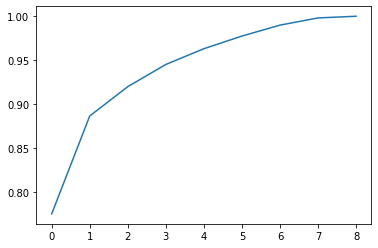

In [25]:
pca = PCA().fit(merged)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [26]:
pca = PCA(n_components = 2, svd_solver = 'full')
merged_graph = pca.fit_transform(merged)

Text(0.5, 1.0, 'PCA of Credit dataset')

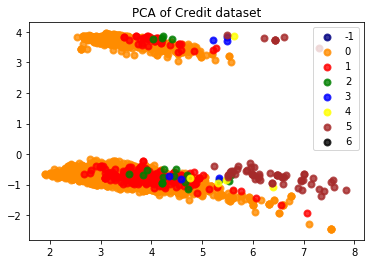

In [45]:
colors = ['navy', 'darkorange', 'red', 'green', 'blue', 'yellow', 'brown', 'black']
target_names = ['-1', '0', '1', '2', '3','4', '5','6']
lw = 2

for color, target_name in zip(colors, target_names):
    merged_graph_1 = merged_graph[(status_names == target_name)['STATUS'].values]
    plt.scatter(merged_graph_1[:,0], merged_graph_1[:,1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Credit dataset')

In [ ]:
merged_graph_1 = merged_graph[merged_graph[:,3] == 1]

In [38]:
(status_names == 1)['STATUS'].values

array([False, False, False, ..., False, False, False])

In [41]:
merged_graph[(status_names == '2')['STATUS'].values]

array([[ 4.2324436 ,  3.85409076],
       [ 4.2081028 ,  3.80906308],
       [ 5.53423908, -0.8951159 ],
       [ 4.24462136, -0.47457578],
       [ 4.73201038, -1.15830459],
       [ 3.83711316, -0.67714895],
       [ 5.33116883, -0.8612349 ],
       [ 5.56558055, -0.70129441],
       [ 3.55599628, -0.6401615 ],
       [ 3.92226893, -0.52707897],
       [ 4.39976289,  3.76281009],
       [ 4.20181962, -0.94363296],
       [ 4.20181962, -0.94363296],
       [ 4.22170683, -0.74586987],
       [ 4.45487778, -0.7085775 ],
       [ 4.47646201, -0.47405464],
       [ 4.66539174, -0.92637074],
       [ 4.03244185,  3.76010146],
       [ 4.69828633, -0.69660872]])

Часть 2. Подготовка кластеров к анализу

Наш датасет готов к кластеризации. Теперь на основе данных об уплате долгов можно составить два основных кластера, к которым мы будем относить людей. Первый кластер - люди, оплащивающие долги вовремя, для них значение столбца STATUS в исходном датасете - C. Второй кластер - люди, которые оплачивают долги с какой-либо задержкой. Также можно выделить различные группы в зависимости от длительности задержки во втором кластере, но для этого недостаточно данных, так как для каждого такого потенциального кластера количество наблюдений не превышает 200 при общем объеме наблюдений больше 20 тысяч.

In [ ]:
merged.loc[merged['STATUS'] == 'C', 'Cluster'] = 1 # на основе названия стобца хотим как-то обратиться к данным
merged.loc[merged['STATUS'] == '0', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '1', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '2', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '3', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '4', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '5', 'Cluster'] = 2
merged = merged.drop('STATUS', 1)
merged

In [ ]:
for i in np.unique(merged["Cluster"]): 
    print( "размер кластера ", int(i), sum(merged["Cluster"]==i))

Как можно заметить, размер первого кластера значительно превышает размер второго. Возьмем равное количество случайных наблюдений из каждого кластера, чтобы сбалансировать их. По 500 случайных наблюдений из каждого.

In [ ]:
#1. Выбираем данные, соответствующие первому кластеру
#2. Случайно перемешиваем
#3. Берем первые 500 наблюдений после перемешивания
#4. Скидываем и удаляем индексы старые
#5. Выбираем только те ряды, которые попали в первые 500 рядов (значения этих рядов в i1)

Data_1 = merged.loc[merged["Cluster"] == 1]
perm = np.random.permutation(Data_1.shape[0])
i1 = perm[:500]
Data_1 = Data_1.reset_index()
Data_1 = Data_1.drop('index', 1)
Data_1 = Data_1.loc[i1]
Data_1

In [ ]:
Data_2 = merged.loc[merged["Cluster"] == 2]
perm = np.random.permutation(Data_2.shape[0])
i2 = perm[:500]
Data_2 = Data_2.reset_index()
Data_2 = Data_2.drop('index', 1)
Data_2 = Data_2.loc[i2]
Data_2

In [ ]:
Data = pd.concat([Data_1, Data_2]) # сцепляем два датасета по горизонтали 
Data = Data.reset_index()
Data = Data.drop('index', 1)
Data

In [ ]:
for i in np.unique(Data["Cluster"]): 
    print( "размер кластера ", int(i), sum(Data["Cluster"]==i))

Теперь наши кластеры более уравновешены. Необходимо подготовить данные к дальнейшему использованию. Разделяем данные и кластеры. 

In [ ]:
# Берем все строки, но из всех столбцов кроме Cluster. Потом из датасета делаем массива
Data_array = Data.loc[:, Data.columns != 'Cluster'] # берем все данные, которые не относятся к Cluster
Data_array = np.asarray(Data_array)
Data_array

In [ ]:
Cluster_names = Data.loc[:, Data.columns.isin(['Cluster'])]
Cluster_names = Cluster_names.reset_index()
Cluster_names = Cluster_names.drop('index', 1)
Cluster_names

Часть 3. Различные способы кластеризации исходных данных.

Сначала воспользуем методом кластеризации K-means. 

In [ ]:
scale = StandardScaler() # пронормируем данные
Data_array = scale.fit_transform(Data_array)

In [ ]:
n_clusters=10
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(Data_array)
    cost.append(kmean.inertia_)  

In [ ]:
# Определим количество кластеров при помощи elbow метода
plt.plot(cost, 'bx-')

Согласно данному графику, необходимо разбивать генеральную совокупность на 3 кластера.

In [ ]:
kmean= KMeans(3)
kmean.fit(Data_array)
labels=kmean.labels_

In [ ]:
K_clusters = pd.concat([Data, pd.DataFrame({'K_cluster':labels})], axis=1)
K_clusters

Посмотрим на характеристики каждого из трех кластеров.

In [ ]:
# посмотрим, как различаются наши кластеры (например, в одном выше зп)
for c in K_clusters:
    grid= sns.FacetGrid(K_clusters, col='K_cluster')
    grid.map(plt.hist, c)

Как мы можем заметить, разбиение на кластеры Kmeans не позволило нам с уверенностью предсказать, к какому кластеру фактически относится человек.Теперь воспользуемся методом PCA для визуализации полученных нами кластеров.

In [ ]:
pca = PCA().fit(Data_array.data) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Будем использовать для снижения размерности 4 главных компоненты, так как они объясняют 80% вариации исходных данных

In [ ]:
pca = PCA(n_components=4, svd_solver='full')
Data_Graph = pca.fit_transform(Data_array)
Data_Graph = np.concatenate((Data_Graph, Cluster_names), axis=1)
column_names = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'Cluster']
Data_Graph = pd.DataFrame(Data_Graph, columns=column_names)
Data_Graph

In [ ]:
colors = ['navy', 'darkorange']
target_names = ['On-time','Late Payment']
lw = 2

for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    plt.scatter(Data_Graph_1.iloc[:,0], Data_Graph_1.iloc[:,1], color=color, alpha=.8, lw=lw,
                label=target_names[i-1])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Credit dataset')

In [ ]:
for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    plt.scatter(Data_Graph_1.iloc[:,1], Data_Graph_1.iloc[:,2], color=color, alpha=.8, lw=lw,
                label=target_names[i-1])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Credit dataset')

Различные двумерные графики не дают возможность разделить наши наблюдения на две группы, попробуем построить график в 3D

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=30)
for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    ax.scatter(Data_Graph_1.iloc[:,1], Data_Graph_1.iloc[:,2], Data_Graph_1.iloc[:,3], cmap=plt.cm.spring, edgecolor='k')

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=120)
for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    ax.scatter(Data_Graph_1.iloc[:,0], Data_Graph_1.iloc[:,1], Data_Graph_1.iloc[:,2], cmap=plt.cm.spring, edgecolor='k')

Данные невозможно разделить на две группы визуальным методом PCA.

Часть 4. Различные способы кластеризации и их результативность на тестовой и тренировочной выборке. Применяем следующие методы: 1) Метод опорных векторов, 2) Гребневый классификатор, 3) Многослойный перцептрон, 4) Стохастический градиенный спуск, 5) Случайный лес, 6) Дерево решений и 7) Метод ближайшего соседа

In [ ]:
Cluster_names = np.asarray(Cluster_names)
Cluster_names = np.ravel(Cluster_names)

Возьмем 80% от датасета как тренировочные данные, оценивать точность классификации будем на оставшихся 20%

In [ ]:
def train( clf, data, labels ):
    n = data.shape[0]
    perm = np.random.permutation( n )
    tr_n = int(0.8 * n)
    train = perm[ :tr_n ]
    valid = perm[ tr_n: ]

    train_dig = data[ train ]
    train_lab = labels[ train ]

    valid_dig = data[ valid ]
    valid_lab = labels[ valid ]

    clf.fit( train_dig, train_lab )

    val_cnt = sum( clf.predict( valid_dig ) == valid_lab ) 
    return clf.predict( valid_dig ), valid_lab

Ниже приведены результаты для различных способов кластеризации данных

In [ ]:
clf = linear_model.RidgeClassifier()
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
clf = svm.SVC( gamma = 0.001 )
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
clf = neural_network.MLPClassifier( )
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
clf = linear_model.SGDClassifier()
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
clf = DecisionTreeClassifier(random_state = 42)
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_impurity_decrease=0.1 )
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
plt.figure(figsize=(25,10))
a = plot_tree(clf, 
              feature_names=Data.columns.values[:-1], 
              class_names=['On-time','Late Payment'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

Как можно заметить, не один из способов кластеризации не дает сколько-нибудь удовлетворительных результатов. Точность предсказиний - 50%, что практически идентично случайным предсказаниям. Попробуем оценить логистическую регрессию с похожими параметрами.

In [ ]:
clf = linear_model.LogisticRegression()
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

In [ ]:
logistic = LogisticRegression()
logistic.fit(Data_array, Cluster_names)
logistic.score(Data_array, Cluster_names)
print('Coefficient: \n', logistic.coef_)
print('Intercept: \n', logistic.intercept_)
print('R² Value: \n', logistic.score(Data_array, Cluster_names))

Как можно заметить, объясняющая сила данной модели достаточно низкая. Приходим к выводу, что кластеризировать такие данные нельзя